# Deep learning

In [1]:
%load_ext autoreload
%autoreload 2

import tasks.data
import tasks.torch_train_eval
import tasks.calibration

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics


import os


DATA_DIR = "data/office"
OUTPUT_DIR = "output"

SOURCE_DATASET = "amazon"
SOURCE_VAL_SPLIT = .15
SOURCE_TEST_SPLIT = .1

TARGET_TEST_SPLIT = 0.3
TARGET_DATASET = "webcam"

RANDOM_SEED = 42
BATCH_SIZE = 3

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
import imageio.v2 as imageio
from torchvision.transforms import v2


def resnet_preprocessor(image: np.ndarray) -> np.ndarray:
    """
    Preprocesses an image for ResNet model.

    :param numpy.ndarray image: The input image.
    :return: Preprocessed image.
    :rtype: numpy.ndarray
    """
    preprocess = torchvision.transforms.Compose(
        [    
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
            v2.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ]
    )

    image = preprocess(image)
    return image


def image_read_func(image_path):
    return imageio.imread(image_path, pilmode='RGB')


In [3]:
import random


def train_val_test_split(
    dataset: tasks.data.ImageDataset,
    train_dataset,
    val_dataset,
    test_dataset,
    val_ratio: float,
    test_ratio: float,
):
    """
    Splits into pure ImageDataset objects, not Subsets, to allow for dynamic changes in the
    underlying data using the custom class API.

    Pass by reference datasets are included instead of being created inside the function, in order
    to support polymorphism (e.g. splitting an UnlabeledImageDataset).
    """
    train_ratio = 1 - val_ratio - test_ratio

    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)

    # Split the dataset into train, validation, and test sets
    random.shuffle(dataset.samples)
    for idx, sample in enumerate(dataset.samples):
        if idx < train_size:
            train_dataset.add(sample[0], sample[1])
        elif idx < train_size + val_size:
            val_dataset.add(sample[0], sample[1])
        else:
            test_dataset.add(sample[0], sample[1])

    return train_dataset, val_dataset, test_dataset


source_dataset = tasks.data.ImageDataset(
    parser_func=image_read_func,
    preprocessing_func=resnet_preprocessor,
)
source_dataset.load_from_directory(os.path.join(DATA_DIR, SOURCE_DATASET))

source_train_dataset = tasks.data.ImageDataset(
    parser_func=source_dataset.parser_func,
    preprocessing_func=source_dataset.preprocessing_func,
    label_encoder=source_dataset.label_encoder,
)
source_val_dataset = tasks.data.ImageDataset(
    parser_func=source_dataset.parser_func,
    preprocessing_func=source_dataset.preprocessing_func,
    label_encoder=source_dataset.label_encoder,
)
source_test_dataset = tasks.data.ImageDataset(
    parser_func=source_dataset.parser_func,
    preprocessing_func=source_dataset.preprocessing_func,
    label_encoder=source_dataset.label_encoder,
)

train_val_test_split(
    source_dataset,
    source_train_dataset,
    source_val_dataset,
    source_test_dataset,
    SOURCE_VAL_SPLIT,
    SOURCE_TEST_SPLIT,
)

  0%|          | 0/31 [00:00<?, ?it/s]

(<tasks.data.ImageDataset at 0x7f4188204940>,
 <tasks.data.ImageDataset at 0x7f4188204970>)

In [4]:
def create_padded_dataloader(
    dataset: tasks.data.ImageDataset,
    shuffle: bool = True,
):
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=shuffle,
        collate_fn=tasks.data.collate_pad,
    )


source_train_loader = create_padded_dataloader(source_train_dataset, shuffle=True)
source_val_loader = create_padded_dataloader(source_val_dataset, shuffle=False)
source_test_loader = create_padded_dataloader(source_test_dataset, shuffle=False)

In [5]:
import pickle


def try_load_weights(model, weights_path: str):
    try:
        model.load_state_dict(torch.load(weights_path))
    except Exception as e:
        print("Cannot load proper weights: ", e)
    return model


def try_load_history(history_path):
    try:
        with open(history_path, 'rb') as handle:
            history = pickle.load(handle)
    except:
        print("No history found in path ", history_path)
        history = None

    return history

In [6]:
import torchinfo


output_path = os.path.join(OUTPUT_DIR, SOURCE_DATASET)

model = torch.hub.load(
    "pytorch/vision:v0.10.0", "resnet18", weights="DEFAULT"
).to(device)
model = try_load_weights(model, os.path.join(output_path, "model.pt"))

torchinfo.summary(model, input_size=(BATCH_SIZE, 3, 300, 300))

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [3, 1000]                 --
├─Conv2d: 1-1                            [3, 64, 150, 150]         9,408
├─BatchNorm2d: 1-2                       [3, 64, 150, 150]         128
├─ReLU: 1-3                              [3, 64, 150, 150]         --
├─MaxPool2d: 1-4                         [3, 64, 75, 75]           --
├─Sequential: 1-5                        [3, 64, 75, 75]           --
│    └─BasicBlock: 2-1                   [3, 64, 75, 75]           --
│    │    └─Conv2d: 3-1                  [3, 64, 75, 75]           36,864
│    │    └─BatchNorm2d: 3-2             [3, 64, 75, 75]           128
│    │    └─ReLU: 3-3                    [3, 64, 75, 75]           --
│    │    └─Conv2d: 3-4                  [3, 64, 75, 75]           36,864
│    │    └─BatchNorm2d: 3-5             [3, 64, 75, 75]           128
│    │    └─ReLU: 3-6                    [3, 64, 75, 75]           --
│

In [7]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_ft = optim.Adam(model.parameters(), lr=0.0005)
# disable lr for adam
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=100000, gamma=0.05)
previous_history = try_load_history(os.path.join(output_path, "history.pickle"))

train = False

if train:
    model, history = tasks.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        source_train_loader,
        source_val_loader,
        output_dir=output_path,
        num_epochs=200,
        patience=10,
        warmup_period=25,
        previous_history=previous_history
    )
else:
    history = previous_history

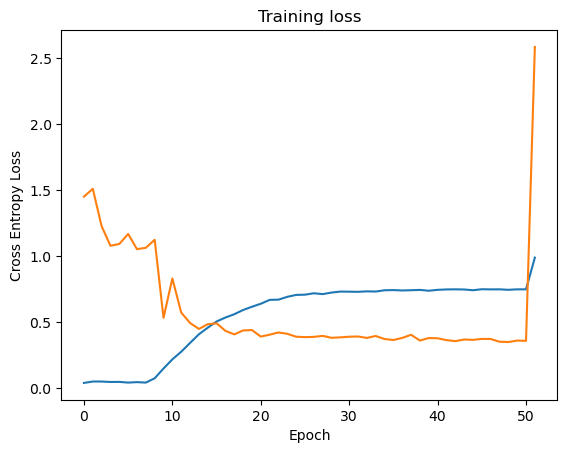

In [8]:
plt.plot(np.array(range(len(history["train_loss"]))), history["train_loss"])
plt.plot(np.array(range(len(history["val_loss"]))), history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training loss")
plt.show()

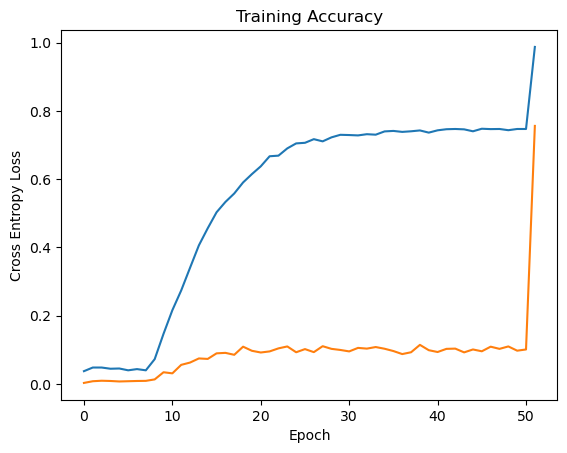

In [9]:
# validation accuracy has been calculated wrong here, ignore it for now
plt.plot(np.array(range(len(history["train_acc"]))), history["train_acc"])
plt.plot(np.array(range(len(history["val_acc"]))), history["val_acc"])

plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Accuracy")
plt.show()

In [10]:
# save logits for later calibration
source_actual, source_predicted = tasks.torch_train_eval.test(
    model, source_test_loader, device
)
class_names = source_dataset.label_encoder.classes_

print(
    sklearn.metrics.classification_report(
        source_actual,
        source_predicted,
        zero_division=0,
        target_names=class_names,
        labels=np.arange(0, len(class_names), 1),
    )
)

  0%|          | 0/95 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       1.00      1.00      1.00         9
            bike       0.75      0.75      0.75         4
     bike_helmet       1.00      1.00      1.00         8
        bookcase       1.00      1.00      1.00         9
          bottle       0.00      0.00      0.00         2
      calculator       0.92      1.00      0.96        12
      desk_chair       1.00      0.83      0.91         6
       desk_lamp       1.00      0.83      0.91         6
desktop_computer       0.92      0.92      0.92        12
    file_cabinet       1.00      1.00      1.00         8
      headphones       0.91      1.00      0.95        10
        keyboard       1.00      1.00      1.00         8
 laptop_computer       0.79      0.92      0.85        12
     letter_tray       0.88      0.64      0.74        11
    mobile_phone       0.88      0.78      0.82         9
         monitor       1.00      0.90      0.95        10
           mo

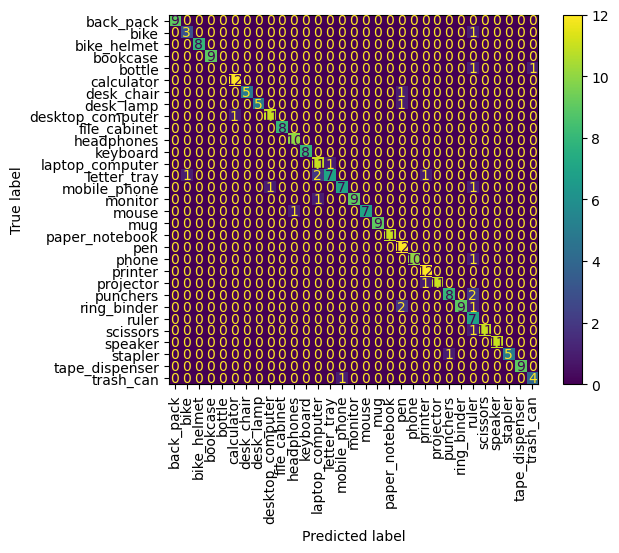

In [11]:
source_cf_matrix = sklearn.metrics.confusion_matrix(source_actual, source_predicted)
display = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=source_cf_matrix, display_labels=class_names
)
display.plot()
plt.xticks(rotation=90)
plt.show()

In [12]:
target_dataset = tasks.data.ImageDataset(
    parser_func=image_read_func,
    preprocessing_func=resnet_preprocessor,
    label_encoder=source_dataset.label_encoder,  # use same classes
)
target_dataset.load_from_directory(os.path.join(DATA_DIR, TARGET_DATASET))

target_train_dataset = tasks.data.ImageDataset(
    parser_func=source_dataset.parser_func,
    preprocessing_func=source_dataset.preprocessing_func,
)
_ = tasks.data.ImageDataset(
    parser_func=source_dataset.parser_func,
    preprocessing_func=source_dataset.preprocessing_func,
)
target_test_dataset = tasks.data.ImageDataset(
    parser_func=source_dataset.parser_func,
    preprocessing_func=source_dataset.preprocessing_func,
)

train_val_test_split(
    target_dataset,
    target_train_dataset,
    _,
    target_test_dataset,
    0,
    TARGET_TEST_SPLIT,
)

target_train_loader = torch.utils.data.DataLoader(target_train_dataset, batch_size=1)
target_test_loader = torch.utils.data.DataLoader(target_test_dataset, batch_size=1)

  0%|          | 0/31 [00:00<?, ?it/s]

In [13]:
target_actual, target_predicted = tasks.torch_train_eval.test(model, target_test_loader, device)
class_names = target_dataset.label_encoder.classes_

print(
    sklearn.metrics.classification_report(
        target_actual,
        target_predicted,
        zero_division=0,
        target_names=class_names,
        labels=np.arange(0, len(class_names), 1),
    )
)

  0%|          | 0/239 [00:00<?, ?it/s]

                  precision    recall  f1-score   support

       back_pack       0.69      0.64      0.67        14
            bike       0.00      0.00      0.00         6
     bike_helmet       0.08      0.17      0.11         6
        bookcase       0.50      0.33      0.40         3
          bottle       0.00      0.00      0.00         5
      calculator       1.00      0.67      0.80         6
      desk_chair       0.00      0.00      0.00        16
       desk_lamp       0.00      0.00      0.00         2
desktop_computer       0.19      0.44      0.27         9
    file_cabinet       0.00      0.00      0.00         5
      headphones       0.50      0.10      0.17        10
        keyboard       0.00      0.00      0.00         5
 laptop_computer       0.00      0.00      0.00         4
     letter_tray       0.00      0.00      0.00         3
    mobile_phone       0.50      0.09      0.15        11
         monitor       0.00      0.00      0.00        11
           mo

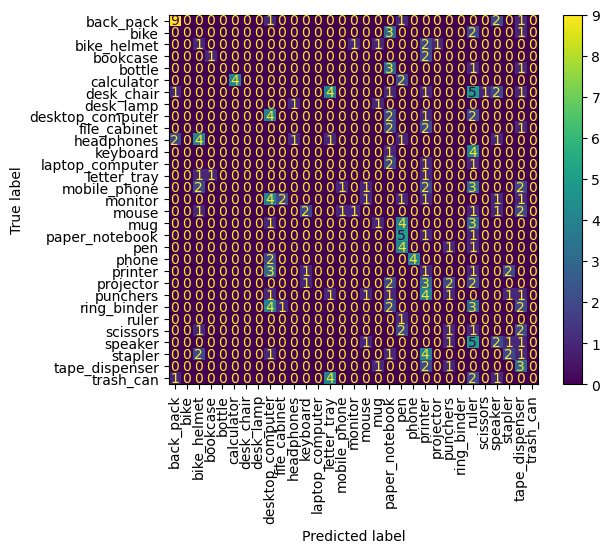

In [14]:
target_cf_matrix = sklearn.metrics.confusion_matrix(target_actual, target_predicted)
display = sklearn.metrics.ConfusionMatrixDisplay(
    confusion_matrix=target_cf_matrix, display_labels=class_names
)
display.plot()
plt.xticks(rotation=90)
plt.show()

## Domain Adaptation

In [15]:
unlabeled_dataset = tasks.data.UnlabeledImageDataset(
    parser_func=image_read_func,
    preprocessing_func=resnet_preprocessor,
)
unlabeled_dataset.load_from_directory(os.path.join(DATA_DIR, TARGET_DATASET))

unlab_train_dataset = tasks.data.UnlabeledImageDataset(
    parser_func=source_dataset.parser_func,
    preprocessing_func=source_dataset.preprocessing_func,
)
_ = tasks.data.UnlabeledImageDataset(
    parser_func=source_dataset.parser_func,
    preprocessing_func=source_dataset.preprocessing_func,
)
unlab_test_dataset = tasks.data.UnlabeledImageDataset(
    parser_func=source_dataset.parser_func,
    preprocessing_func=source_dataset.preprocessing_func,
)
train_val_test_split(
    unlabeled_dataset,
    unlab_train_dataset,
    _,
    unlab_test_dataset,
    0,
    TARGET_TEST_SPLIT,
)

unlab_train_loader = torch.utils.data.DataLoader(unlab_train_dataset, batch_size=1)
unlab_test_loader = torch.utils.data.DataLoader(unlab_test_dataset, batch_size=1)

  0%|          | 0/31 [00:00<?, ?it/s]

In [16]:
# from https://openaccess.thecvf.com/content_cvpr_2018/CameraReady/1410.pdf section 4.1


def adaptive_threshold(classification_accuracy: float, rho: float = 3) -> float:
    return 1 / (1 + np.exp(-rho * classification_accuracy))


def select_samples(
    model: nn.Module, dataloader, threshold: float, device: str
) -> tuple[list[str], list[int]]:
    selected_samples_ls = []
    predicted_labels_ls = []

    # Iterate over batches
    for inputs, file_path in tqdm(dataloader):
        inputs = inputs.to(device)

        # Forward pass
        with torch.no_grad():
            outputs = model(inputs)
            _, predicted_labels = torch.max(outputs, 1)

        # Store results
        for logit, pred in zip(outputs, predicted_labels):
            confidence = torch.max(nn.Softmax()(logit))

            if confidence > threshold:
                selected_samples_ls.append(file_path[0])
                predicted_labels_ls.append(pred.item())

    return selected_samples_ls, predicted_labels_ls

In [17]:
threshold = adaptive_threshold(classification_accuracy=0.98)
samples = select_samples(model, unlab_train_loader, threshold, device)

print("Before: source ", len(source_train_dataset))
print("Before: target ", len(unlab_train_dataset))

for image_path, class_id in zip(samples[0], samples[1]):
    # update datasets and recreate dataloaders
    unlab_train_dataset.remove(image_path)
    unlab_train_loader = torch.utils.data.DataLoader(unlab_train_dataset, batch_size=1)

    source_train_dataset.add(image_path, class_id)
    source_train_loader = create_padded_dataloader(source_train_dataset, shuffle=True)

print("After : source", len(source_train_dataset))
print("After: target ", len(unlab_train_dataset))

  0%|          | 0/556 [00:00<?, ?it/s]

/home/dimits/anaconda3/envs/tf/lib/python3.9/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Before: source  2112
Before: target  556
After : source 2132
After: target  536


## Dustbin